In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import NuSVR
#Keras imports
from keras import backend as K

from keras.layers import Input, Dense
from keras.optimizers import RMSprop, SGD, Adagrad,Adam,Adadelta,Adamax,Nadam
from keras.models import Sequential, Model
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam

from time import time

1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


In [2]:
#LINEAR
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

#Guardar en csv columnas desde start hasta en de un dataframe.
def store_column_pd(df,columns_start,columns_end,url):
    temp_df =df.iloc[:,columns_start:columns_end]
    temp_df.to_csv(url)
    return temp_df


In [20]:
#Data from files
data_algebra = pd.read_csv("/home/dcasals/graph-edit-distance/data/algebra_features.txt")
data_medoids = pd.read_csv("/home/dcasals/graph-edit-distance/data/vectors_medoids.csv")
print(data_algebra.shape,data_medoids.shape)

(19171, 28) (19113, 28)


In [21]:
gpf_algebra = data_algebra.merge(data_medoids, left_on='query_id', right_on='id')
gpf_algebra.head()
gpf_algebra = gpf_algebra.drop(columns=["query_id","Unnamed: 27_x","Unnamed: 27_y"])
gpf_algebra.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'path*', 'pathN*', 'path+', 'pathN+', 'notoneof',
       'tolist', 'order', 'project', 'distinct', 'reduced', 'multi', 'top',
       'group', 'assign', 'sequence', 'slice', 'treesize', 'id', 'time',
       'pcs25', 'pcs25.1', 'pcs25.2', 'pcs25.3', 'pcs25.4', 'pcs25.5',
       'pcs25.6', 'pcs25.7', 'pcs25.8', 'pcs25.9', 'pcs25.10', 'pcs25.11',
       'pcs25.12', 'pcs25.13', 'pcs25.14', 'pcs25.15', 'pcs25.16', 'pcs25.17',
       'pcs25.18', 'pcs25.19', 'pcs25.20', 'pcs25.21', 'pcs25.22', 'pcs25.23',
       'pcs25.24'],
      dtype='object')

In [22]:
nunique = gpf_algebra.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
gpf_algebra = gpf_algebra.drop(cols_to_drop, axis=1)
#/////
new_cols = list(gpf_algebra.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
gpf_algebra.columns = new_cols
#/////
gpf_algebra = gpf_algebra[gpf_algebra['time'] < 15000]
X_temp, X_test = train_test_split(gpf_algebra, test_size=0.25, random_state=42, shuffle=True)
#/////
X_train, X_val = train_test_split(
    X_temp, test_size=0.30, random_state=42,shuffle=True)
print("Shapes : Train: {} Val: {}, Test: {}".format(X_train.shape, X_val.shape, X_test.shape))

Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')
Shapes : Train: (9947, 43) Val: (4264, 43), Test: (4737, 43)


,triple,bgp,join,leftjoin,union,filter,graph,extend,minus,order,...,pcs15,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24
15051,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.153846,0.285714,0.50000,0.400000,0.285714,0.200000,0.285714,0.181818,0.181818
278,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.142857,0.250000,0.40000,0.666667,0.222222,0.166667,0.250000,0.166667,0.166667
13390,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.153846,0.285714,0.50000,0.400000,0.285714,0.200000,0.285714,0.181818,0.181818
17106,4.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.181818,0.400000,0.25000,0.222222,0.400000,0.222222,0.400000,0.222222,0.222222
1225,16.0,16.0,2.0,1.0,12.0,2.0,0.0,0.0,0.0,0.0,...,0.048780,0.058824,0.054054,0.04878,0.048780,0.052632,0.051282,0.054054,0.057143,0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.40000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
1619,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.40000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
2355,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.133333,0.222222,0.40000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
14335,4.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.250000,1.000000,0.25000,0.222222,0.500000,0.222222,1.000000,0.333333,0.333333


In [24]:
data_tpf = pd.read_csv("datasetlsq_output_rlearningtfeat.csv", delimiter="ᶶ")


/home/dcasals/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [25]:
data_tpf = data_tpf.drop(columns=["Unnamed: 4",'execTime'])

In [26]:
from keras.utils import to_categorical

def uri_2_index_seq(x,uri2Index):
    """transform uris to sequences"""
    lista  = [uri2Index[a] for a in x]
#     print(lista)
    return lista
def get_joins(x):
    lista = [a for a in x.split(",") if a != ""]
    if len(lista) == 1:
        return []
    valsjoins = []
    for i in range(len(lista))[::2]:
        valsjoins.append([lista[i],lista[i+1]])
    return valsjoins

In [27]:
data_tpf['joinsv1'] =  data_tpf['joins'].apply(lambda x: get_joins(x))

In [28]:
def preprocesar_joins_data(x):
    #create indexes
    zeros = np.zeros((len(uri2Index), len(uri2Index)))
    for val in x:
        first = val[0]
        second= val[1]
        findex = uri2Index[first]
        sindex = uri2Index[second]

        if findex <= sindex:
            zeros[findex,sindex] = 1
        else:
            zeros[sindex,findex] = 1
#             Se retorna la mitad de arriba de la matrix
    return zeros[np.triu_indices(len(uri2Index))]

def extractIndex_joins_data(data):
    #create indexes
    index = 0
    uri2Index = {}
    index2Uri = {}

    for lista in  data.values:
        for val in lista:
            first = val[0]
            second= val[1]
            if first not in uri2Index:
                uri2Index[first] = index
                index2Uri[index] = first
                index +=1
            if second not in uri2Index:
                uri2Index[second] = index
                index2Uri[index] = second
                index +=1

    return uri2Index, index2Uri

In [29]:
uri2Index, index2Uri = extractIndex_joins_data(data_tpf['joinsv1'])

In [30]:
def merge_df(data1, data2, left_on, right_on):
    res = data1.merge(data2, left_on=left_on, right_on=right_on)
    if left_on == right_on:
        res = res.drop(columns=left_on)
    else:
        res = res.drop(columns=[left_on, right_on])
    print(res.columns)
    return res

In [31]:
X_train = merge_df(X_train, data_tpf[['id','joinsv1']], 'id', 'id')

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4',
       'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12',
       'pcs13', 'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20',
       'pcs21', 'pcs22', 'pcs23', 'pcs24', 'joinsv1'],
      dtype='object')


In [32]:
X_val = merge_df(X_val, data_tpf[['id','joinsv1']], 'id', 'id')

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4',
       'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12',
       'pcs13', 'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20',
       'pcs21', 'pcs22', 'pcs23', 'pcs24', 'joinsv1'],
      dtype='object')


In [33]:
X_test = merge_df(X_test, data_tpf[['id','joinsv1']], 'id', 'id')

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4',
       'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12',
       'pcs13', 'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20',
       'pcs21', 'pcs22', 'pcs23', 'pcs24', 'joinsv1'],
      dtype='object')


In [34]:
y_train = X_train[['time']]
X_train = X_train.drop(columns=['time'])
y_val = X_val[['time']]
X_val = X_val.drop(columns=['time'])
y_test = X_test[['time']]
X_test = X_test.drop(columns=['time'])

In [35]:
X_train_join = X_train['joinsv1'].apply(lambda x: preprocesar_joins_data(x))
X_val_join   =   X_val['joinsv1'].apply(lambda x: preprocesar_joins_data(x))
X_test_join  =  X_test['joinsv1'].apply(lambda x: preprocesar_joins_data(x))

In [36]:
X_train_join = pd.DataFrame.from_items(zip(X_train_join.index, X_train_join.values)).T
X_val_join   = pd.DataFrame.from_items(zip(X_val_join.index, X_val_join.values)).T
X_test_join  = pd.DataFrame.from_items(zip(X_test_join.index, X_test_join.values)).T

/home/dcasals/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.
/home/dcasals/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  
/home/dcasals/rnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
def train_autoencoder(x_train, x_val,encoding_dim,verbose):
    # Set callback functions to early stop training and save the best model so far
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=10),
                ]
    # def autoencode_pd(df):
    # this is the size of our encoded representations
    # this is our input placeholder
    input_img = Input(shape=(x_train.shape[1],))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x_train.shape[1], activation='linear')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer=Nadam(learning_rate=0.0001), loss='mse')
    print(autoencoder.summary())
    autoencoder.fit(x_train, x_train,
                    epochs=300,
             batch_size=120,
                    shuffle=True,
                    validation_data=(x_val, x_val),
                    verbose=verbose,
                    callbacks=callbacks_best)
    return autoencoder

In [38]:
model = train_autoencoder(X_train_join,X_val_join, encoding_dim=300,verbose=False)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24531)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               7359600   
_________________________________________________________________
dense_2 (Dense)              (None, 24531)             7383831   
Total params: 14,743,431
Trainable params: 14,743,431
Non-trainable params: 0
_________________________________________________________________
None


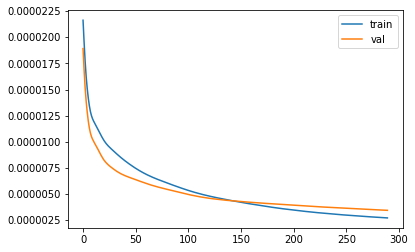

In [39]:
plt.plot(model.history.history['loss'][10:],label="train")
plt.plot(model.history.history['val_loss'][10:],label="val")
plt.legend()
plt.show()

In [40]:
#Standarizar
scalerx = StandardScaler()
x_train_scaled = scalerx.fit_transform(X_train.drop(columns=['joinsv1']));
x_val_scaled   = scalerx.transform(X_val.drop(columns=['joinsv1']));
x_test_scaled  = scalerx.fit_transform(X_test.drop(columns=['joinsv1']));

scaled_df_train = pd.DataFrame(x_train_scaled, index=X_train.index, columns=X_train.drop(columns=['joinsv1']).columns)
scaled_df_val = pd.DataFrame(x_val_scaled, index=X_val.index, columns=X_train.drop(columns=['joinsv1']).columns)
scaled_df_test = pd.DataFrame(x_test_scaled, index=X_test.index, columns=X_train.drop(columns=['joinsv1']).columns)

In [83]:
#Save data
scaled_df_train.join(y_train).to_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv", index=False)
scaled_df_val.join(y_val).to_csv("/home/dcasals/jupyter/mlproject/xval_std.csv", index=False)
scaled_df_test.join(y_test).to_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv", index=False)

In [84]:
#READ data
# scaled_df_train = pd.read_csv("/home/dcasals/jupyter/mlproject/xtrain_std.csv")
# scaled_df_val   = pd.read_csv("/home/dcasals/jupyter/mlproject/xval_std.csv")
# scaled_df_test  = pd.read_csv("/home/dcasals/jupyter/mlproject/xtest_std.csv")

# y_train = scaled_df_train['time']
# y_val   = scaled_df_val['time']
# y_test  = scaled_df_test['time']
# scaled_df_train = scaled_df_train.drop(columns=['time'])
# scaled_df_val = scaled_df_val.drop(columns=['time'])
# scaled_df_test = scaled_df_test.drop(columns=['time'])

KeyError: 'time'

In [41]:
scaled_df_train = scaled_df_train[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_val = scaled_df_val[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_test = scaled_df_test[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_train.shape,scaled_df_val.shape,scaled_df_test.shape

((9947, 34), (4264, 34), (4735, 34))

In [87]:
scaled_df_train.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [42]:
#Pass Target to log scale
y_train_log = np.log(y_train.values.reshape(-1, 1))
y_val_log = np.log(y_val.values.reshape(-1, 1))
y_test_log = np.log(y_test.values.reshape(-1, 1))

#Standarizar target
scalery = StandardScaler()
y_train_log_std = scalery.fit_transform(y_train_log)
y_val_log_std = scalery.transform(y_val_log)
y_test_log_std = scalery.transform(y_test_log)

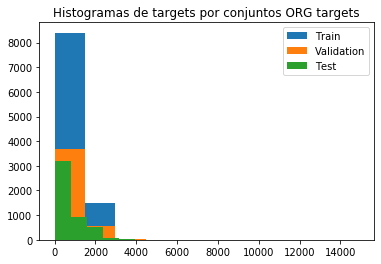

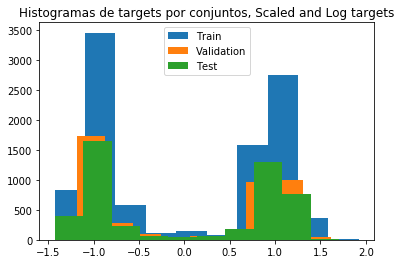

In [43]:
plt.title("Histogramas de targets por conjuntos ORG targets")
plt.hist(y_train.values.reshape(-1, 1),label="Train")
plt.hist(y_val.values.reshape(-1, 1),label="Validation")
plt.hist(y_test.values.reshape(-1, 1),label="Test")
plt.legend()
plt.show()
plt.title("Histogramas de targets por conjuntos, Scaled and Log targets")
plt.hist(y_train_log_std,label="Train")
plt.hist(y_val_log_std,label="Validation")
plt.hist(y_test_log_std,label="Test")
plt.legend()
plt.show()

<span style="color:blue">

### Entrenando RNN. Primer enfoque

- Datos escalados
- Targets escalados y en escala logarítmica.


In [62]:
y_pred = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_train.values).reshape(-1, 1)))
y_pred_val = np.exp(scalery.inverse_transform(model_trained[0].predict(scaled_df_val.values).reshape(-1, 1)))

r2_train = r2_score(y_train, y_pred)
r2_val  =  r2_score( y_val, y_pred_val)
r2_train,r2_val

(0.47419900477928645, 0.4733220472796885)

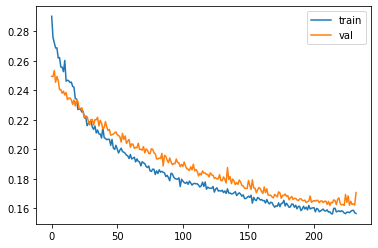

### Update, columnas originales del paper.


In [8]:
scaled_df_train.columns

Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [45]:
scaled_df_train = scaled_df_train[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_val = scaled_df_val[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_test = scaled_df_test[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
scaled_df_train.shape,scaled_df_val.shape,scaled_df_test.shape

((9947, 34), (4264, 34), (4735, 34))

In [46]:
model.save("autoencoder_joins.h5")

In [105]:
def build_aecjoinpluslegacydata(autoencoder, x_train, y_train, x_val, y_val,x_trainjoin, x_valjoin, neuronas, scalery, epochs, optimizer, dropout,verbose=True):
    strneuronas = "-".join([str(integer) for integer in neuronas])
    print("USING {}".format(strneuronas))
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata{}.h5'.format(strneuronas),
                                      monitor='val_loss', save_best_only=True
                                     )]
#     joins_input = autoencoder.layers[0]
    joins_input = Input(shape=(24531,), name='join_input')
    joins_output = autoencoder.layers[1](joins_input)

    dense_input = Input(shape=(34,), name='dense_input')    

    # We stack a deep densely-connected network on top
    x = concatenate([dense_input, joins_output])
    for n in neuronas:
        x = Dense(n, activation='relu')(x)
        x = Dropout(dropout)(x)

#     x = concatenate([lstm_type_out, lstm_pred_out])

    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='linear', name='main_output')(x)
    
    #Build model
    model = Model(inputs=[dense_input, joins_input], outputs=[main_output])
#     model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    print(model.summary())
    from keras.utils import plot_model
    plot_model(model, to_file='model4.png')
    t0 = time()
    history_org = model.fit([x_train.values,x_trainjoin],
                            y_train,
                            epochs=epochs,
                            batch_size=120,
                            validation_data=([x_val.values,x_valjoin], y_val),
                            callbacks=callbacks_best,
                            verbose=verbose
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    scoresshow([model,history_org])
    return [model,history_org]


In [152]:
model.layers[0].input.shape

TensorShape([None, 24531])

In [49]:
from keras.layers import concatenate

### Aplicación del modelo respecto al entrenamiento de un autoencoder como parte inicial del modelo.

USING 300-496-441
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

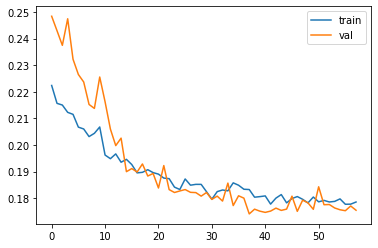

USING 300-496-441
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

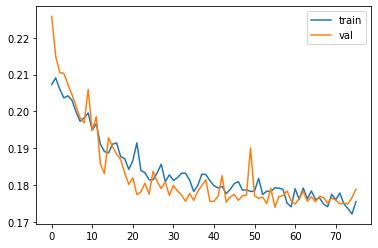

USING 300-496-441
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

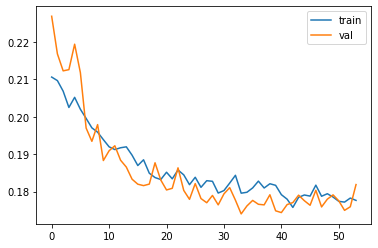

USING 300-496-441
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

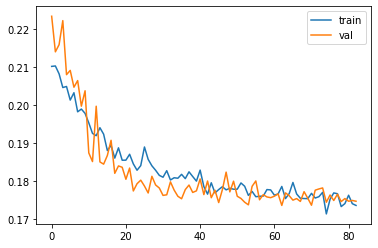

USING 300-496-441
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

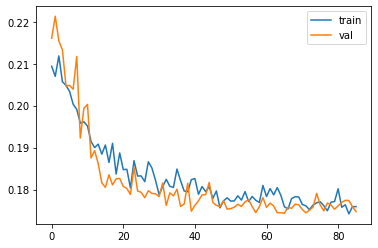

USING 300-496-441
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

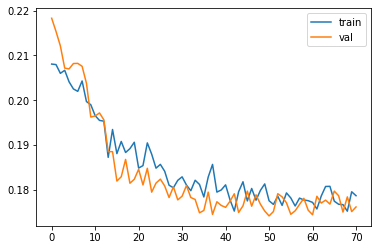

USING 300-496-441
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

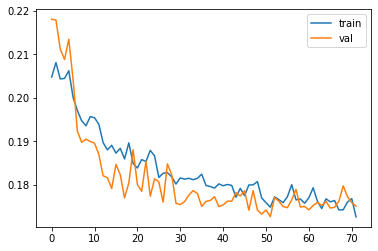

USING 300-496-441
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

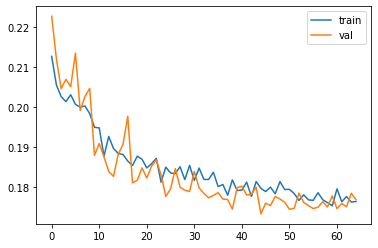

USING 300-496-441
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

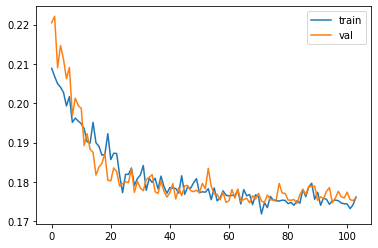

USING 300-496-441
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

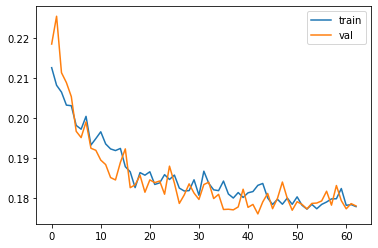

In [106]:
import random 
epochs=450
dropout=0.5
optimizer=Adam(learning_rate=0.0005)
units_by_layer = [random.randrange(300,600,20) for val in range(numcapas)]
for i in range(10):
    result = build_aecjoinpluslegacydata(
        model,
        scaled_df_train,
        y_train_log_std,
        scaled_df_val,
        y_val_log_std,
        X_train_join,
        X_val_join,
        units_by_layer.sort(reverse = True),
        scalery,
        epochs,
        optimizer,
        dropout,
        False)

# y_pred_org_test = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_test.values).reshape(-1, 1)))
# rmseval = np.sqrt(mean_squared_error(y_test, y_pred_org_test ))
# r2val = r2_score(y_test, y_pred_org_test )

# print("MSE:{} y R2: {}".format(rmseval, r2val))

In [74]:
#Prediction
y_pred_org_train = np.exp(scalery.inverse_transform(result[0].predict([scaled_df_train.values,X_train_join]).reshape(-1, 1)))
y_pred_org_val = np.exp(scalery.inverse_transform(result[0].predict([scaled_df_val.values,X_val_join]).reshape(-1, 1)))
y_pred_org_test = np.exp(scalery.inverse_transform(result[0].predict([scaled_df_test.values,X_test_join]).reshape(-1, 1)))

rmse_train = np.sqrt(mean_squared_error(y_train_log_std, y_pred_org_train))
rmse_val   = np.sqrt(mean_squared_error(y_val_log_std, y_pred_org_val))
rmse_test  = np.sqrt(mean_squared_error(y_test_log_std, y_pred_org_test))

print("RMSE Train", np.sqrt(mean_squared_error(y_train, y_pred_org_train)))
print("RMSE VAL", np.sqrt(mean_squared_error(y_val, y_pred_org_val)))
print("RMSE TEST", np.sqrt(mean_squared_error(y_test, y_pred_org_test)))
plt.plot(result[1].history['loss'][13:],label="train")
plt.plot(result[1].history['val_loss'][13:],label="val")
plt.legend()
plt.show()

RMSE Train 630.2480342159195
RMSE VAL 567.4057366100996
RMSE TEST 461.51914411261293


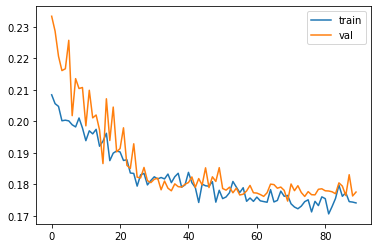

In [75]:
plt.plot(result[1].history['loss'][13:],label="train")
plt.plot(result[1].history['val_loss'][13:],label="val")
plt.legend()
plt.show()

In [82]:
epochs=450
dropout=0.5
optimizer=Adam(learning_rate=0.0005)
result = build_aecjoinpluslegacydata(
    model,
    scaled_df_train,
    y_train_log_std,
    scaled_df_val,
    y_val_log_std,
    X_train_join,
    X_val_join,
    600 , 
    400, 
    300,
    scalery,
    epochs,
    optimizer,
    dropout)

# y_pred_org_test = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_test.values).reshape(-1, 1)))
# rmseval = np.sqrt(mean_squared_error(y_test, y_pred_org_test ))
# r2val = r2_score(y_test, y_pred_org_test )

# print("MSE:{} y R2: {}".format(rmseval, r2val))

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[10][0]            

In [77]:
#Prediction
def scoresshow(result):
    y_pred_org_train = np.exp(scalery.inverse_transform(result[0].predict([scaled_df_train.values,X_train_join]).reshape(-1, 1)))
    y_pred_org_val = np.exp(scalery.inverse_transform(result[0].predict([scaled_df_val.values,X_val_join]).reshape(-1, 1)))
    y_pred_org_test = np.exp(scalery.inverse_transform(result[0].predict([scaled_df_test.values,X_test_join]).reshape(-1, 1)))

    rmse_train = np.sqrt(mean_squared_error(y_train_log_std, y_pred_org_train))
    rmse_val   = np.sqrt(mean_squared_error(y_val_log_std, y_pred_org_val))
    rmse_test  = np.sqrt(mean_squared_error(y_test_log_std, y_pred_org_test))

    print("RMSE Train", np.sqrt(mean_squared_error(y_train, y_pred_org_train)))
    print("RMSE VAL", np.sqrt(mean_squared_error(y_val, y_pred_org_val)))
    print("RMSE TEST", np.sqrt(mean_squared_error(y_test, y_pred_org_test)))
    plt.plot(result[1].history['loss'][13:],label="train")
    plt.plot(result[1].history['val_loss'][13:],label="val")
    plt.legend()
    plt.show()

USING 560-500-500
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

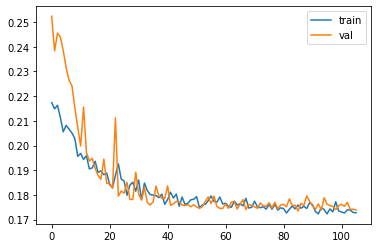

USING 560-500-500
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

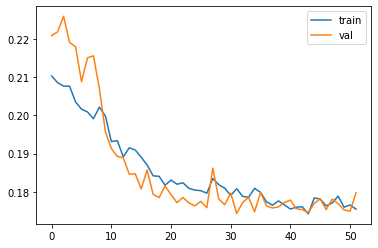

USING 560-500-500
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

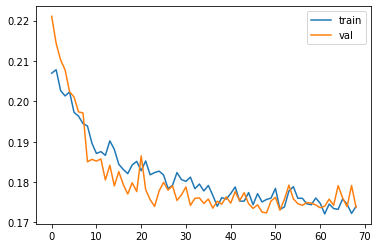

USING 560-500-500
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

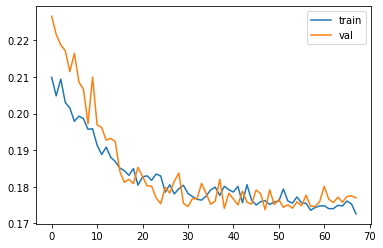

USING 560-500-500
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_25 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

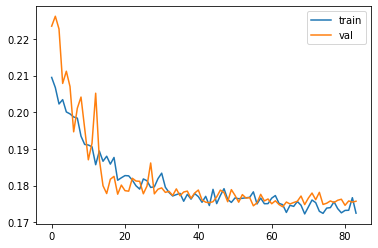

USING 560-500-500
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_26 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

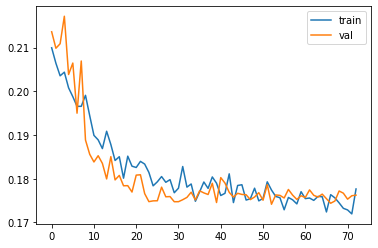

USING 560-500-500
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

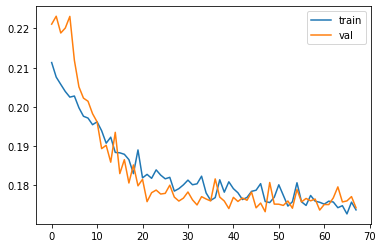

USING 560-500-500
Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

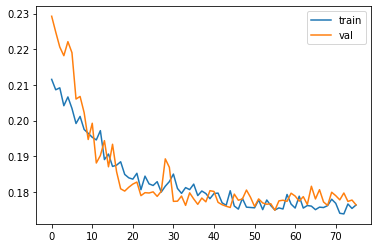

USING 560-500-500
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

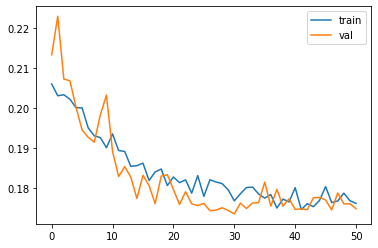

USING 560-500-500
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
join_input (InputLayer)         (None, 24531)        0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        (None, 34)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          7359600     join_input[0][0]                 
__________________________________________________________________________________________________
concatenate_30 (Concatenate)    (None, 334)          0           dense_input[0][0]                
                                                                 dense_1[

In [ ]:
import random 
epochs=450
dropout=0.5
optimizer=Adam(learning_rate=0.0005)
units_by_layer = [random.randrange(300,600,20) for val in range(3)]
units_by_layer.sort(reverse = True)
resultslist = []
for i in range(10):
    result = build_aecjoinpluslegacydata(
        model,
        scaled_df_train,
        y_train_log_std,
        scaled_df_val,
        y_val_log_std,
        X_train_join,
        X_val_join,
        units_by_layer,
        scalery,
        epochs,
        optimizer,
        dropout,
        False)
    resultslist.append([units_by_layer,result])
# y_pred_org_test = np.exp(scalery.inverse_transform(model_trained_aenc[0].predict(scaled_df_test.values).reshape(-1, 1)))
# rmseval = np.sqrt(mean_squared_error(y_test, y_pred_org_test ))
# r2val = r2_score(y_test, y_pred_org_test )

# print("MSE:{} y R2: {}".format(rmseval, r2val))